In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sase-on2/delay_8141-polarix-2024-01-25T041105.npy
/kaggle/input/sase-on2/lhpulses_zero-sase_on-polarix-2023-11-08T032511.npy
/kaggle/input/sase-on2/lhpulses_zero-sase_on-polarix-2023-11-08T034310.npy
/kaggle/input/sase-on2/lhpulses_two-sase_on-polarix-2023-11-08T021604.npy
/kaggle/input/sase-on2/lhpulses_zero-sase_on-polarix-2023-11-08T021827.npy
/kaggle/input/sase-on2/lhpulses_two-sase_on-polarix-2023-11-08T034442.npy
/kaggle/input/sase-on2/lhpulses_two-sase_on-polarix-2023-11-08T031510.npy
/kaggle/input/sase-on2/lhpulses_one-sase_on-polarix-2023-11-08T021740.npy


In [4]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=28b7a361bb1bedaa2d4e82016c08c43b427c0093b868176a1918f6a5dca84eba
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [4]:
#!wget -O traindata.pkl https://tu-dortmund.sciebo.de/s/kpCMGPutwk6vKOP/download

--2024-03-04 14:02:49--  https://tu-dortmund.sciebo.de/s/kpCMGPutwk6vKOP/download
Resolving tu-dortmund.sciebo.de (tu-dortmund.sciebo.de)... 128.176.1.2
Connecting to tu-dortmund.sciebo.de (tu-dortmund.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 587827929 (561M) [application/octet-stream]
Saving to: 'traindata.pkl'

traindata.pkl       100%[===================>] 560.60M  33.2MB/s    in 18s     

2024-03-04 14:03:08 (31.4 MB/s) - 'traindata.pkl' saved [587827929/587827929]



In [5]:
import torch
from torch.utils.data import Dataset
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [51]:
train_data = pd.read_pickle("traindata.pkl")
train_df, val_df = train_test_split(train_data, test_size = 0.2)

train_X, train_Y = train_df['train_X'], train_df['train_Y']
val_X, val_Y = val_df['train_X'], val_df['train_Y']

Train set size : 2048 	 Validation set size : 512
(141, 176) (141, 176)


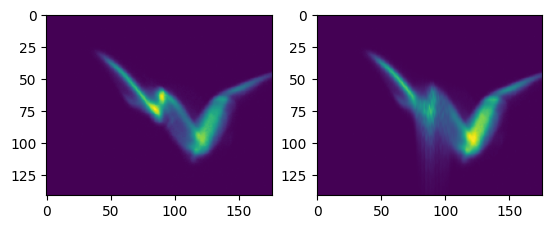

In [52]:
print(f"Train set size : {train_X.shape[-1]} \t Validation set size : {val_X.shape[-1]}")
idx = 600
fig, ax = plt.subplots(1,2)
ax[0].imshow(train_X[idx])
ax[1].imshow(train_Y[idx])

print(train_X[0].shape, train_Y[0].shape)

In [53]:
DEVICE = 'cuda'

EPOCHS = 30
LR = 1e-4
IMAGE_SIZE_X, IMAGE_SIZE_Y = 140, 200
BATCH_SIZE = 32

In [54]:
import albumentations as alb

def get_augs():
  return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y)
  ], is_check_shapes=False)

def get_val_augs():
  return alb.Compose([
      alb.Resize(IMAGE_SIZE_X, IMAGE_SIZE_Y),
  ], is_check_shapes=False)

In [55]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return(len(self.df))

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image = row.train_Y
    mask = row.train_X
    

    if self.augmentations:
      data = self.augmentations(image = image) #, mask = mask)
      image = data['image']
      data = self.augmentations(image = mask)
      mask = data['image']

    image = np.expand_dims(image,axis=0)
    mask = np.expand_dims(mask,axis=0)

    return image, mask

In [56]:
trainset = SegmentationDataset(train_df, get_augs())
valset = SegmentationDataset(val_df, get_augs())

print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(valset)}")

Size of Trainset : 2048
Size of Validset : 512


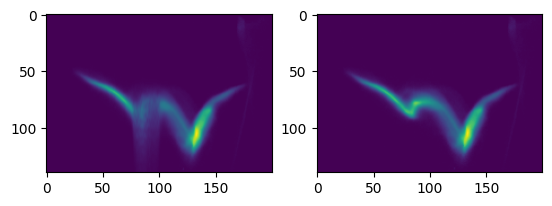

In [57]:
idx = 650
image, mask = trainset[idx]
fig, ax = plt.subplots(1,2)
ax[0].imshow(image[0])
ax[1].imshow(mask[0])

In [63]:
image.shape

(1, 140, 200)

In [58]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle = False)
valloader = DataLoader(valset, batch_size= BATCH_SIZE)

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [99]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.conv0 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv1 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Bottleneck
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv7 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv10 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv11 = nn.Conv2d(32, 1, 1)
        

    def forward(self, x):
        # Encoder
        x0 = F.relu(self.conv0(x))
        
        x1 = F.relu(self.conv1(x0))
        x1 = F.relu(self.conv2(x1))
        x2 = self.pool1(x1)
        
        x2 = F.relu(self.conv3(x2))
        x2 = F.relu(self.conv4(x2))
        x3 = self.pool2(x2)
        
        # Bottleneck
        x3 = F.relu(self.conv5(x3))
        x3 = F.relu(self.conv6(x3))
        
        # Decoder
        x4 = self.upconv1(x3)
        x4 = torch.cat([x4, x2], dim=1)
        x4 = F.relu(self.conv7(x4))
        x4 = F.relu(self.conv8(x4))
        
        x5 = self.upconv2(x4)
        x5 = torch.cat([x5, x1], dim=1)
        x5 = F.relu(self.conv9(x5))
        x5 = F.relu(self.conv10(x5))
        x5 = self.conv11(x5)
        return x5

# Instantiate the model
model = UNet()

# Print the model architecture
print(model)

UNet(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv2): ConvTranspose2d(128, 64, kernel_

In [100]:
def train_function(data_loader, model, criterion, optimizer):

    model.train()
    total_loss = 0.0

    for inputs, targets in tqdm(data_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def eval_function(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)

            total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
model = UNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = np.Inf

train_L, val_L = [], []
for i in range(EPOCHS):

    train_loss = train_function(trainloader, model, criterion, optimizer)
    train_L.append(train_loss)
    val_loss = eval_function(valloader, model)
    val_L.append(val_loss)

    if val_loss < best_val_loss:
        #torch.save(model.state_dict(), 'best_model.pt')
        best_val_loss = val_loss

    print(f"Epoch: {i+1}   Train loss: {train_loss}  Val_loss: {val_loss}")
    
plt.plot(train_L, label="train loss")
plt.plot(val_L, label="test loss")
plt.legend()


 50%|█████     | 32/64 [00:07<00:07,  4.35it/s]

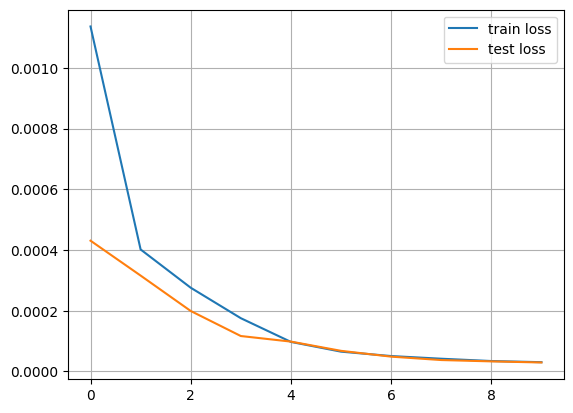

In [65]:
plt.plot(train_L, label="train loss")
plt.plot(val_L, label="test loss")
plt.grid()
plt.legend()

Text(0.5, 1.0, 'original image')

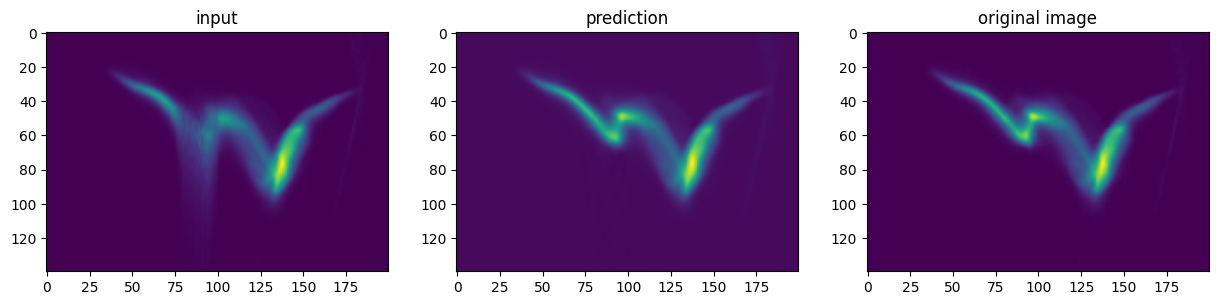

In [98]:
val_inp = [inputs for inputs,outputs in valloader]
val_out = [outputs for inputs,outputs in valloader]
train_inp = [inputs for inputs,outputs in trainloader]
train_out = [outputs for inputs,outputs in trainloader]

idx = 8
valX = val_inp[4][idx]
valX = valX.to(device)
valY = val_out[4][idx]

model.eval()
with torch.no_grad():
    val_pred = model(valX.unsqueeze(0))
    
valX = valX.squeeze().cpu()
valY = valY.squeeze().cpu()
val_pred = val_pred.squeeze().cpu()

fig, ax = plt.subplots(1,3, figsize=(15,8))
ax[0].imshow(valX)
ax[0].set_title("input")
ax[1].imshow(val_pred)
ax[1].set_title("prediction")
ax[2].imshow(valY)
ax[2].set_title("original image")

In [81]:
def model_pred(model, img, plot=False):
    #device = 'cuda'
    img = img / np.max(img)
    kernel_size = 5
    img = cv2.medianBlur(img, kernel_size)
    M, N = (np.array(img.shape) // 5)
    img = cv2.resize(img, (N, M))
    data = get_augs()(image = img)
    img = data['image']
    
    img = np.expand_dims(img, axis=0)
    testX = torch.tensor(img).to(device)
    
    model.eval()
    with torch.no_grad():
        test_pred = model(testX.unsqueeze(0))

    testX = testX.squeeze().cpu()
    test_pred = test_pred.squeeze().cpu()
    
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(15,8))
        ax[0].imshow(testX)
        ax[0].set_title("Input")
        ax[1].imshow(test_pred)
        ax[1].set_title("Model Prediction")
    
    return testX, test_pred

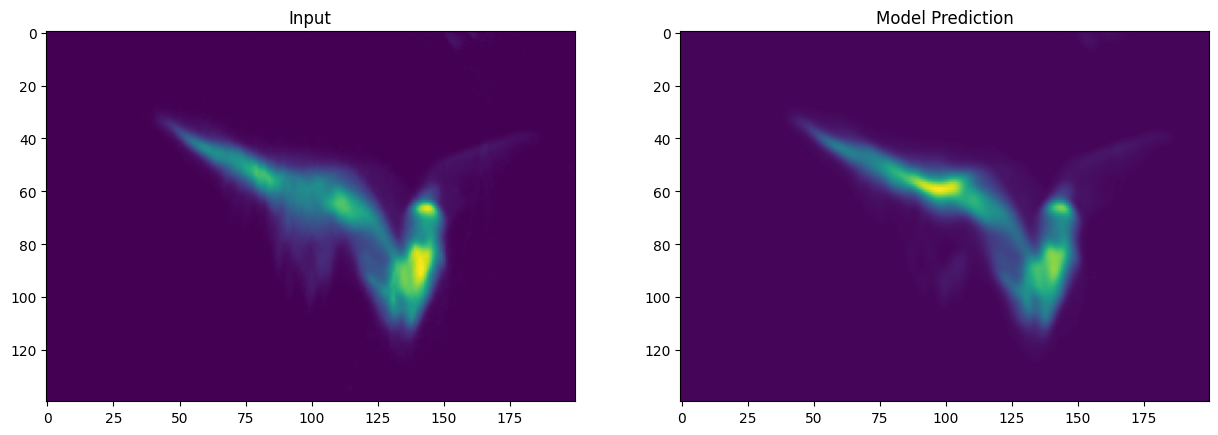

In [88]:
sase_on = np.load('/kaggle/input/sase-on2/lhpulses_zero-sase_on-polarix-2023-11-08T032511.npy').astype(np.float32)
img = sase_on[8]
pred_in, pred_out = model_pred(model, img, plot=True)
#plt.close()

## Use the model to do the prediction for all lasing-on images 

In [91]:
from pathlib import Path
from glob import glob

path = Path("/kaggle/working/")
save_result = path / "results"

if not save_result.exists():
    save_result.mkdir(parents=True)
    
sase_on_files = glob("/kaggle/input/sase-on2/*.npy")

In [92]:
for sase_on in sase_on_files:
    path = Path(sase_on)
    img_list = np.load(sase_on).astype(np.float32)
    
    N_img = img_list.shape[0]
    for i, img in tqdm(enumerate(img_list)):
        pred_in, pred_out = model_pred(model, img, plot=True)
        plt.savefig(save_result / f"{path.stem}_{i}")
        plt.close()

In [94]:
import shutil
shutil.make_archive("results", 'zip', "/kaggle/working/results")

'/kaggle/working/results.zip'

## To load a saved model

In [6]:
model = UNet()
state_dict = torch.load("/kaggle/working/best_model.pt")
model.load_state_dict(state_dict)
model.to(device)

UNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (conv7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv9): Conv2d(128, 64, kernel_size=(3, 3), st

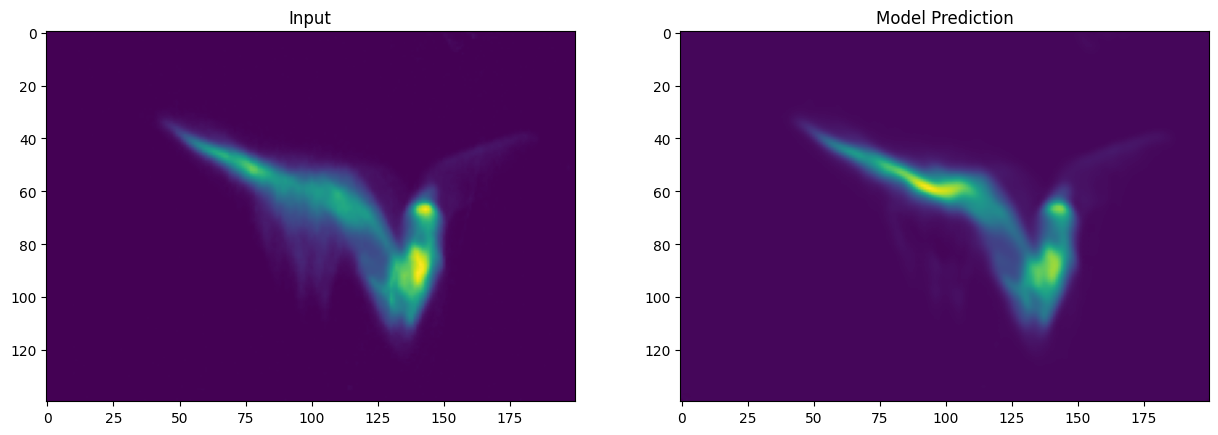

In [91]:
sase_on = np.load('/kaggle/input/sase-on2/lhpulses_zero-sase_on-polarix-2023-11-08T032511.npy').astype(np.float32)
img = sase_on[5]
pred_in, pred_out = model_pred(model, img, plot=True)

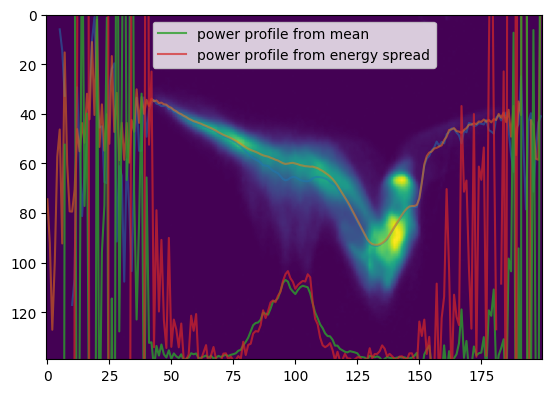

In [92]:
pixel_values = np.tile(np.arange(pred_in.shape[0]), (pred_in.shape[1],1)).T

mean_px_sase_on  = np.ma.average(pixel_values, weights=pred_in, axis=0)
mean_px_sase_off = np.ma.average(pixel_values, weights=pred_out, axis=0)
mean_diff = mean_px_sase_on - mean_px_sase_off

std_px_sase_on = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_on) ** 2, weights=pred_in, axis=0))
std_px_sase_off = np.ma.sqrt(np.ma.average((pixel_values - mean_px_sase_off) ** 2, weights=pred_out, axis=0))
std_diff = std_px_sase_on**2 - std_px_sase_off**2

plt.imshow(pred_in)
plt.plot(mean_px_sase_on, alpha=0.5)
plt.plot(mean_px_sase_off, alpha=0.5)
plt.ylim(139,0)
plt.plot(140 - mean_diff*5, label = "power profile from mean", alpha=0.8)
plt.plot(140 - std_diff* 5**(2/3) * 0.15, label = "power profile from energy spread", alpha=0.7)
plt.legend()